**MSc in Big Data & Analytics Kosmas Katsioulas | Part C MOTMetrics**

# **Libraries & Packages**

In [1]:
!pip -q install --index-url https://download.pytorch.org/whl/cpu torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1
!pip -q install deep_sort_realtime==1.3.2 motmetrics==1.4.0 opencv-python-headless==4.10.0.84 pandas==2.2.2 numpy==2.0.0 matplotlib==3.8.4 seaborn==0.13.2 tqdm==4.67

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 134.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [2]:
import os, glob, re, json, time, math, random, warnings
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import motmetrics as mm
from pathlib import Path
from zipfile import ZipFile
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from deep_sort_realtime.deepsort_tracker import DeepSort

In [3]:
SEED = 0
random.seed(SEED); np.random.seed(SEED)

In [4]:
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["savefig.dpi"] = 150
warnings.filterwarnings("ignore")

# **Mount Google Drive**

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False
print("IN_COLAB:", IN_COLAB)

Mounted at /content/drive
IN_COLAB: True


# **Useful Paths**

In [6]:
zip_path   = '/content/drive/MyDrive/Diploma/UNIRI_HBD_Dataset/uniri-hbd.zip'
extract_to = '/content/uniri-hbd'

In [7]:
if os.path.exists(zip_path) and not os.path.exists(extract_to):

    with ZipFile(zip_path, 'r') as zf:

        zf.extractall(extract_to)

    print("Dataset extracted ->", extract_to)

else:

    print("Zip not used or dataset already extracted.")

Dataset extracted -> /content/uniri-hbd


In [8]:
base_dir = os.path.join(extract_to, "handball_s")
scenes_dir = os.path.join(base_dir, "scenes")
dets_dir = os.path.join(base_dir, "player_detections")

In [9]:
trackresults_dir = "/content/Tracking_Results"
os.makedirs(trackresults_dir, exist_ok=True)

In [10]:
cache_dir = "/content/Track_Data"
os.makedirs(cache_dir, exist_ok=True)

# **Useful Functions**

**Parse Function**

In [11]:
def load_uniri_csv(csv_path: str) -> pd.DataFrame:

    rows, current_frame = [], None

    with open(csv_path, "r") as f:

        for raw in f:

            line = raw.strip()

            if not line:

                continue

            if line.lower().startswith("frame"):

                nums = re.findall(r"\d+", line)
                current_frame = int(nums[0]) if nums else None
                continue

            parts = re.split(r"[,\s]+", line.strip(", "))

            if current_frame is None or len(parts) < 5:

                continue

            try:

                x1, y1, x2, y2, conf = map(float, parts[:5])
                rows.append([current_frame, x1, y1, x2, y2, conf])

            except Exception:

                pass

    df = pd.DataFrame(rows, columns=["frame","x1","y1","x2","y2","conf"])
    return df.sort_values("frame").reset_index(drop=True)

In [12]:
def video_path_from_csv(csv_path: str) -> str:

    action = os.path.basename(os.path.dirname(csv_path))
    stem   = Path(csv_path).stem

    return os.path.join(scenes_dir, action, f"{stem}.mp4")

In [13]:
def color_for_id(track_id: int) -> tuple:

    rng = np.random.default_rng(track_id * 9973 + SEED)

    return (int(rng.integers(50,255)),int(rng.integers(50,255)), int(rng.integers(50,255)))

# **Silver Ground Truth**

In [14]:
def _iou_mat(A: np.ndarray, B: np.ndarray) -> np.ndarray:

    if A.size==0 or B.size==0:

        return np.zeros((len(A),len(B)), dtype=np.float32)

    ax1,ay1,ax2,ay2 = A[:,0],A[:,1],A[:,2],A[:,3]
    bx1,by1,bx2,by2 = B[:,0],B[:,1],B[:,2],B[:,3]
    ix1 = np.maximum(ax1[:,None], bx1[None,:]); iy1 = np.maximum(ay1[:,None], by1[None,:])
    ix2 = np.minimum(ax2[:,None], bx2[None,:]); iy2 = np.minimum(ay2[:,None], by2[None,:])
    iw  = np.maximum(0.0, ix2-ix1); ih = np.maximum(0.0, iy2-iy1)
    inter = iw*ih
    areaA = np.maximum(0.0, ax2-ax1)*np.maximum(0.0, ay2-ay1)
    areaB = np.maximum(0.0, bx2-bx1)*np.maximum(0.0, by2-by1)

    return (inter / np.maximum(1e-9, areaA[:,None] + areaB[None,:] - inter)).astype(np.float32)

In [15]:
def build_gt_motion(csv_path: str, iou_thr=0.3, max_age=2, ema=0.6) -> pd.DataFrame:

    df = load_uniri_csv(csv_path)
    tracks, active, next_id, state = {}, {}, 1, {}

    for fr in sorted(df["frame"].unique()):

        D = df.loc[df.frame==fr, ["x1","y1","x2","y2"]].to_numpy()

        if not active or len(D)==0:

            for b in D:

                tid = next_id; next_id += 1
                tracks.setdefault(tid, []).append((fr,*b))
                active[tid] = {"box": b, "age": 0}
                cx,cy = (b[0]+b[2])/2, (b[1]+b[3])/2
                state[tid] = np.array([cx,cy], dtype=np.float32)


            for tid in list(active.keys()):

                if len(D)==0:

                    active[tid]["age"] += 1

                    if active[tid]["age"] > max_age: del active[tid]
            continue

        tids = list(active.keys())
        A = np.vstack([active[t]["box"] for t in tids])
        I = _iou_mat(A, D)
        centers_D = np.c_[ (D[:,0]+D[:,2])/2, (D[:,1]+D[:,3])/2 ]
        motion = np.zeros_like(I)

        for ti, tid in enumerate(tids):

            exp = state[tid][None,:]
            dist = np.linalg.norm(centers_D - exp, axis=1)
            scale = np.sqrt((A[ti,2]-A[ti,0])*(A[ti,3]-A[ti,1]) + 1e-6)
            motion[ti,:] = np.exp(-dist / (2.0*scale))

        C = 1.0 - (I * motion)
        r, c = linear_sum_assignment(C)
        matched_det, matched_tr = set(), set()

        for ri, ci in zip(r, c):

            if I[ri,ci] >= iou_thr:

                b   = D[ci]; tid = tids[ri]
                tracks.setdefault(tid, []).append((fr,*b))
                active[tid] = {"box": b, "age": 0}
                cx,cy = (b[0]+b[2])/2, (b[1]+b[3])/2
                state[tid] = ema*state[tid] + (1-ema)*np.array([cx,cy], np.float32)
                matched_det.add(ci); matched_tr.add(tid)

            else:

                active[tids[ri]]["age"] += 1

        for j in range(len(D)):

            if j not in matched_det:

                tid = next_id; next_id += 1
                b = D[j]
                tracks.setdefault(tid, []).append((fr,*b))
                active[tid] = {"box": b, "age": 0}
                cx,cy = (b[0]+b[2])/2, (b[1]+b[3])/2
                state[tid] = np.array([cx,cy], dtype=np.float32)

        for tid in list(active.keys()):

            if tid not in matched_tr:

                active[tid]["age"] += 1

                if active[tid]["age"] > max_age:

                    del active[tid]

    rows=[]

    for tid, items in tracks.items():


        for (f,x1,y1,x2,y2) in items:

            rows.append([f,tid,x1,y1,x2,y2])

    return pd.DataFrame(rows, columns=["frame","id","x1","y1","x2","y2"]).sort_values(["frame","id"]).reset_index(drop=True)

In [16]:
def build_silver_gt_for_clip(csv_path: str, out_csv: str|None=None, iou_thr=0.3, max_age=2, ema=0.6):

    gt_df = build_gt_motion(csv_path, iou_thr=iou_thr, max_age=max_age, ema=ema)

    if out_csv is None:

        out_csv = os.path.join(cache_dir, f"{Path(csv_path).stem}_Silver_GT_Kosmas_Katsioulas_ME2109.csv")

    gt_df.to_csv(out_csv, index=False)
    print("Saved Silver-GT:", out_csv, "| rows:", len(gt_df))

    return gt_df, out_csv

# **DeepSort Predictions**

In [17]:
def detections_for_frame(df: pd.DataFrame, frame_idx: int, conf_thr: float=0.2, to_tlwh: bool=True):

    sub = df[df.frame == frame_idx]
    out=[]

    for _, r in sub.iterrows():

        if float(r.conf) < conf_thr:

            continue

        if to_tlwh:

            w = max(0.0, r.x2 - r.x1); h = max(0.0, r.y2 - r.y1)

            if w <= 1 or h <= 1:

                continue

            out.append(([float(r.x1), float(r.y1), float(w), float(h)], float(r.conf), 'player'))

        else:

            out.append(([float(r.x1), float(r.y1), float(r.x2), float(r.y2)], float(r.conf), 'player'))

    return out

In [18]:
def build_pred_tracks_with_deepsort(csv_path: str, out_csv: str|None=None, conf_thr=0.2, max_age=15, n_init=3, max_cos_dist=0.4, embedder_name='mobilenet', use_half=False):

    df  = load_uniri_csv(csv_path)
    vid = video_path_from_csv(csv_path)
    cap = cv2.VideoCapture(vid); assert cap.isOpened(), f"Failure to open: {vid}"

    tracker = DeepSort(max_age=max_age, n_init=n_init, max_cosine_distance=max_cos_dist, embedder=embedder_name, half=use_half, bgr=True)

    rows=[]
    frames = sorted(df.frame.unique())

    for f in frames:

        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, f-1))
        ok, frame = cap.read()

        if not ok or frame is None:
            continue

        dets = detections_for_frame(df, f, conf_thr=conf_thr, to_tlwh=True)
        tracks = tracker.update_tracks(dets, frame=frame)

        for tr in tracks:

            if not tr.is_confirmed():
                continue

            tid = tr.track_id
            l,t,r,b = tr.to_ltrb()
            rows.append([f, tid, float(l), float(t), float(r), float(b)])

    cap.release()

    pred = pd.DataFrame(rows, columns=["frame","id","x1","y1","x2","y2"]).sort_values(["frame","id"]).reset_index(drop=True)

    if out_csv is None:

        out_csv = os.path.join(cache_dir, f"{Path(csv_path).stem}_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv")

    pred.to_csv(out_csv, index=False)
    print("Saved Pred:", out_csv, "| rows:", len(pred))

    return pred, out_csv

# **MOTMetrics & Bootstrap CI**

In [19]:
def bbox_to_xywh(df: pd.DataFrame):

    w = (df.x2 - df.x1).clip(lower=0)
    h = (df.y2 - df.y1).clip(lower=0)
    x = df.x1 + 0.5*w
    y = df.y1 + 0.5*h

    return x, y, w, h

In [20]:
def eval_mot(gt_df: pd.DataFrame, pr_df: pd.DataFrame) -> pd.DataFrame:

    acc = mm.MOTAccumulator(auto_id=True)
    frames = sorted(set(gt_df.frame.unique()) | set(pr_df.frame.unique()))

    for f in frames:

        gtf = gt_df[gt_df.frame==f]; prf = pr_df[pr_df.frame==f]
        gi, pi = list(gtf.id.values), list(prf.id.values)

        if not gi and not pi:

            continue

        gx,gy,gw,gh = bbox_to_xywh(gtf)
        px,py,pw,ph = bbox_to_xywh(prf)
        cost = np.ones((len(gi), len(pi)), dtype=float)

        for i,(xg,yg,wg,hg) in enumerate(zip(gx,gy,gw,gh)):

            ax1,ay1 = xg-wg/2, yg-hg/2; ax2,ay2 = xg+wg/2, yg+hg/2

            for j,(xp,yp,wp,hp) in enumerate(zip(px,py,pw,ph)):
                bx1,by1 = xp-wp/2, yp-hp/2; bx2,by2 = xp+wp/2, yp+hp/2
                ix1,iy1 = max(ax1,bx1), max(ay1,by1)
                ix2,iy2 = min(ax2,bx2), min(ay2,by2)
                iw,ih   = max(0.0, ix2-ix1), max(0.0, iy2-iy1)
                inter   = iw*ih
                aarea   = max(0.0, ax2-ax1)*max(0.0, ay2-ay1)
                barea   = max(0.0, bx2-bx1)*max(0.0, by2-by1)
                union   = max(1e-9, aarea+barea-inter)
                iou     = inter/union if union>0 else 0.0
                cost[i,j] = 1.0 - iou

        acc.update(gi, pi, cost if cost.size>0 else np.empty((0,0)))

    mh = mm.metrics.create()
    summary = mh.compute(
        acc,
        metrics=['num_frames','mota','idf1','precision','recall','mostly_tracked','mostly_lost','num_switches'],
        name='overall'
    )

    return summary

In [21]:
def mot_bootstrap_ci(gt_df, pr_df, n_boot=200, alpha=0.05, seed=0):

    rng = np.random.default_rng(seed)
    frames = sorted(set(gt_df.frame.unique()) | set(pr_df.frame.unique()))
    mh = mm.metrics.create()
    vals=[]

    for _ in range(n_boot):

        sample = rng.choice(frames, size=len(frames), replace=True)
        gtb = gt_df[gt_df.frame.isin(sample)]
        prb = pr_df[pr_df.frame.isin(sample)]
        acc = mm.MOTAccumulator(auto_id=True)

        for f in sample:

            gtf = gtb[gtb.frame==f]; prf = prb[prb.frame==f]
            gi, pi = list(gtf.id.values), list(prf.id.values)

            if not gi and not pi:

                continue

            gx,gy,gw,gh = bbox_to_xywh(gtf); px,py,pw,ph = bbox_to_xywh(prf)
            cost = np.ones((len(gi),len(pi)), dtype=float)

            for i,(xg,yg,wg,hg) in enumerate(zip(gx,gy,gw,gh)):

                ax1,ay1 = xg-wg/2, yg-hg/2; ax2,ay2 = xg+wg/2, yg+hg/2

                for j,(xp,yp,wp,hp) in enumerate(zip(px,py,pw,ph)):

                    bx1,by1 = xp-wp/2, yp-hp/2; bx2,by2 = xp+wp/2, yp+hp/2
                    ix1,iy1 = max(ax1,bx1), max(ay1,by1)
                    ix2,iy2 = min(ax2,bx2), min(ay2,by2)
                    iw,ih   = max(0.0, ix2-ix1), max(0.0, iy2-iy1)
                    inter   = iw*ih
                    aarea   = max(0.0, ax2-ax1)*max(0.0, ay2-ay1)
                    barea   = max(0.0, bx2-bx1)*max(0.0, by2-by1)
                    union   = max(1e-9, aarea+barea-inter)
                    iou     = inter/union if union>0 else 0.0
                    cost[i,j] = 1.0 - iou

            acc.update(gi, pi, cost if cost.size>0 else np.empty((0,0)))

        s = mh.compute(acc, metrics=['mota','idf1'], name='boot').loc['boot']
        vals.append([float(s['mota']), float(s['idf1'])])

    M = np.asarray(vals)
    lo = np.quantile(M, alpha/2, axis=0); hi = np.quantile(M, 1-alpha/2, axis=0); mu = M.mean(axis=0)

    return {"mota_mean":mu[0], "mota_lo":lo[0], "mota_hi":hi[0], "idf1_mean":mu[1], "idf1_lo":lo[1], "idf1_hi":hi[1]}

In [22]:
def switches_per_minute(mot_summary_df: pd.DataFrame, video_path: str) -> float:

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    nF  = cap.get(cv2.CAP_PROP_FRAME_COUNT) or 1
    cap.release()
    minutes = max(1e-6, (nF / fps) / 60.0)
    switches = float(mot_summary_df.loc['overall','num_switches'])

    return switches / minutes

In [23]:
def track_fragmentation(pred_df: pd.DataFrame) -> pd.DataFrame:

    out=[]

    for tid, g in pred_df.groupby("id"):

        fr = sorted(g['frame'].astype(int).tolist())
        gaps=0

        for i in range(1,len(fr)):

            if fr[i] != fr[i-1]+1:

                gaps += 1

        out.append({"id":int(tid), "fragments":gaps, "len":len(fr)})

    return pd.DataFrame(out).sort_values(["fragments","len"], ascending=[False,True])

In [24]:
actions = ['dribbling','passing','crossing','jump-shot','running','defence','shot']

In [25]:
clips_to_eval = []
for act in actions:

    cand = sorted(glob.glob(os.path.join(dets_dir, act, "*.csv")))

    if cand:

        clips_to_eval.append(cand[0])

In [26]:
print(f"A total of {len(clips_to_eval)} clips.")
for p in clips_to_eval:
    print("-", Path(p).stem)

A total of 7 clips.
- dribbling_KS_10
- passing_KS_100
- crossing_KS_1
- jump-shot_KS_10
- running_KS_47
- defence_KS_1
- shot_KS_10


In [27]:
all_rows = []
for csv_path in clips_to_eval:
    stem = Path(csv_path).stem
    print("\n=== ", stem, "===")

    # Silver Ground Truth
    gt_df, gt_csv = build_silver_gt_for_clip(csv_path, iou_thr=0.3, max_age=2, ema=0.6)

    # DeepSORT
    pr_df, pr_csv = build_pred_tracks_with_deepsort(csv_path, conf_thr=0.2)

    # MOTmetrics
    summ = eval_mot(gt_df, pr_df)
    out_sum = os.path.join(trackresults_dir, f"{stem}_MOT_Summary_Kosmas_Katsioulas.csv")
    summ.to_csv(out_sum)
    display(summ)

    # Bootstrap CIs
    ci = mot_bootstrap_ci(gt_df, pr_df, n_boot=200, alpha=0.05, seed=SEED)
    print("Bootstrap CI:", ci)

    # Diagnostics
    vid_path = video_path_from_csv(csv_path)
    swpm = switches_per_minute(summ, vid_path)
    frag = track_fragmentation(pd.read_csv(pr_csv))
    print(f"Switches/min: {swpm:.2f}")
    display(frag.head())

    rec = summ.loc['overall'].to_dict()
    rec.update({"clip": stem,
                "mota_ci": f"{ci['mota_mean']:.3f} [{ci['mota_lo']:.3f},{ci['mota_hi']:.3f}]",
                "idf1_ci": f"{ci['idf1_mean']:.3f} [{ci['idf1_lo']:.3f},{ci['idf1_hi']:.3f}]",
                "switches_per_min": swpm})
    all_rows.append(rec)


===  dribbling_KS_10 ===
Saved Silver-GT: /content/Track_Data/dribbling_KS_10_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 1503
Saved Pred: /content/Track_Data/dribbling_KS_10_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 961


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,65,0.634065,0.753247,1.0,0.639388,24,142,8


Bootstrap CI: {'mota_mean': np.float64(0.6214422524803038), 'mota_lo': np.float64(0.5710504495068517), 'mota_hi': np.float64(0.6646645401382244), 'idf1_mean': np.float64(0.7532455249133456), 'idf1_lo': np.float64(0.7086250409701736), 'idf1_hi': np.float64(0.786736806159414)}
Switches/min: 354.11


,id,fragments,len
23,83,0,5
22,79,0,10
20,71,0,14
21,75,0,14
19,67,0,15



===  passing_KS_100 ===
Saved Silver-GT: /content/Track_Data/passing_KS_100_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 2333
Saved Pred: /content/Track_Data/passing_KS_100_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 1571


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,81,0.656237,0.678791,0.998727,0.672525,49,174,36


Bootstrap CI: {'mota_mean': np.float64(0.6433284854840327), 'mota_lo': np.float64(0.6128536145558118), 'mota_hi': np.float64(0.6746948874438385), 'idf1_mean': np.float64(0.6829153099156643), 'idf1_lo': np.float64(0.6642433650485013), 'idf1_hi': np.float64(0.7003812430929813)}
Switches/min: 1278.72


,id,fragments,len
29,100,0,2
28,98,0,5
27,89,0,9
24,74,0,18
26,78,0,19



===  crossing_KS_1 ===
Saved Silver-GT: /content/Track_Data/crossing_KS_1_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 1747
Saved Pred: /content/Track_Data/crossing_KS_1_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 1391


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,82,0.792215,0.847674,1.0,0.796222,24,89,7


Bootstrap CI: {'mota_mean': np.float64(0.7738482492901992), 'mota_lo': np.float64(0.7410412842376586), 'mota_hi': np.float64(0.8031629990902382), 'idf1_mean': np.float64(0.8483726290959317), 'idf1_lo': np.float64(0.8257640769344905), 'idf1_hi': np.float64(0.865924918781726)}
Switches/min: 245.61


,id,fragments,len
20,35,0,16
21,38,0,16
6,7,0,20
19,31,0,23
17,26,0,41



===  jump-shot_KS_10 ===
Saved Silver-GT: /content/Track_Data/jump-shot_KS_10_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 3493
Saved Pred: /content/Track_Data/jump-shot_KS_10_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 2467


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,98,0.697395,0.797651,1.0,0.70627,38,163,31


Bootstrap CI: {'mota_mean': np.float64(0.6783259155257465), 'mota_lo': np.float64(0.6520512927285178), 'mota_hi': np.float64(0.7037662476172127), 'idf1_mean': np.float64(0.79972577378636), 'idf1_lo': np.float64(0.7808420073945969), 'idf1_hi': np.float64(0.8122449510022564)}
Switches/min: 910.11


,id,fragments,len
44,125,0,1
45,127,0,1
43,123,0,3
42,122,0,4
41,114,0,10



===  running_KS_47 ===
Saved Silver-GT: /content/Track_Data/running_KS_47_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 3177
Saved Pred: /content/Track_Data/running_KS_47_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 2350


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,114,0.724583,0.650624,0.998723,0.738747,68,211,42


Bootstrap CI: {'mota_mean': np.float64(0.7047872200559905), 'mota_lo': np.float64(0.67258618071054), 'mota_hi': np.float64(0.729793263290923), 'idf1_mean': np.float64(0.6526135007525334), 'idf1_lo': np.float64(0.631368823635649), 'idf1_hi': np.float64(0.6696167634101627)}
Switches/min: 1059.99


,id,fragments,len
33,119,0,2
34,122,0,2
32,117,0,3
31,108,0,12
14,19,0,17



===  defence_KS_1 ===
Saved Silver-GT: /content/Track_Data/defence_KS_1_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 1031
Saved Pred: /content/Track_Data/defence_KS_1_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 708


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,81,0.669253,0.695802,0.995763,0.683802,19,95,12


Bootstrap CI: {'mota_mean': np.float64(0.6504828094166409), 'mota_lo': np.float64(0.6105731635071091), 'mota_hi': np.float64(0.6876699074054599), 'idf1_mean': np.float64(0.6983155028687429), 'idf1_lo': np.float64(0.6777546024285155), 'idf1_hi': np.float64(0.7255203711841443)}
Switches/min: 426.24


,id,fragments,len
12,39,0,2
11,37,0,6
8,15,0,35
10,25,0,42
7,13,0,48



===  shot_KS_10 ===
Saved Silver-GT: /content/Track_Data/shot_KS_10_Silver_GT_Kosmas_Katsioulas_ME2109.csv | rows: 2665
Saved Pred: /content/Track_Data/shot_KS_10_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 2057


,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches
overall,65,0.758724,0.779754,1.0,0.771857,51,143,35


Bootstrap CI: {'mota_mean': np.float64(0.7435465977672018), 'mota_lo': np.float64(0.6883558509345271), 'mota_hi': np.float64(0.7772196129533705), 'idf1_mean': np.float64(0.7812671167938945), 'idf1_lo': np.float64(0.7505604605443821), 'idf1_hi': np.float64(0.8045268700386783)}
Switches/min: 1549.22


,id,fragments,len
43,109,0,4
42,106,0,6
41,105,0,7
40,98,0,12
29,39,0,16


In [28]:
df_mot_all = pd.DataFrame(all_rows).set_index("clip").sort_index()
display(df_mot_all)
df_mot_all.to_csv(os.path.join(trackresults_dir,"Mot_Summary_All_Clips_Kosmas_Katsioulas_ME2109.csv"))

,num_frames,mota,idf1,precision,recall,mostly_tracked,mostly_lost,num_switches,mota_ci,idf1_ci,switches_per_min
clip,,,,,,,,,,,
crossing_KS_1,82.0,0.792215,0.847674,1.000000,0.796222,24.0,89.0,7.0,"0.774 [0.741,0.803]","0.848 [0.826,0.866]",245.607805
defence_KS_1,81.0,0.669253,0.695802,0.995763,0.683802,19.0,95.0,12.0,"0.650 [0.611,0.688]","0.698 [0.678,0.726]",426.240000
dribbling_KS_10,65.0,0.634065,0.753247,1.000000,0.639388,24.0,142.0,8.0,"0.621 [0.571,0.665]","0.753 [0.709,0.787]",354.107077
jump-shot_KS_10,98.0,0.697395,0.797651,1.000000,0.706270,38.0,163.0,31.0,"0.678 [0.652,0.704]","0.800 [0.781,0.812]",910.109388
passing_KS_100,81.0,0.656237,0.678791,0.998727,0.672525,49.0,174.0,36.0,"0.643 [0.613,0.675]","0.683 [0.664,0.700]",1278.720000
running_KS_47,114.0,0.724583,0.650624,0.998723,0.738747,68.0,211.0,42.0,"0.705 [0.673,0.730]","0.653 [0.631,0.670]",1059.991579
shot_KS_10,65.0,0.758724,0.779754,1.000000,0.771857,51.0,143.0,35.0,"0.744 [0.688,0.777]","0.781 [0.751,0.805]",1549.218462


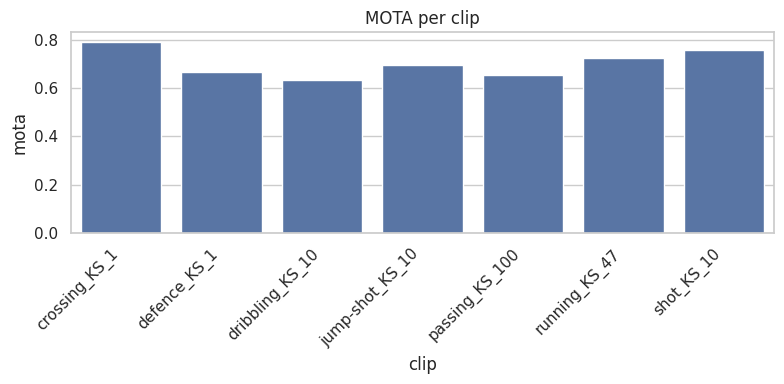

In [29]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=df_mot_all.reset_index(), x="clip", y="mota")
ax.set_title("MOTA per clip")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(trackresults_dir,"Bars_Mota_per_Clip_Kosmas_Katsioulas_ME2109.png"))
plt.show()

<Figure size 800x400 with 0 Axes>

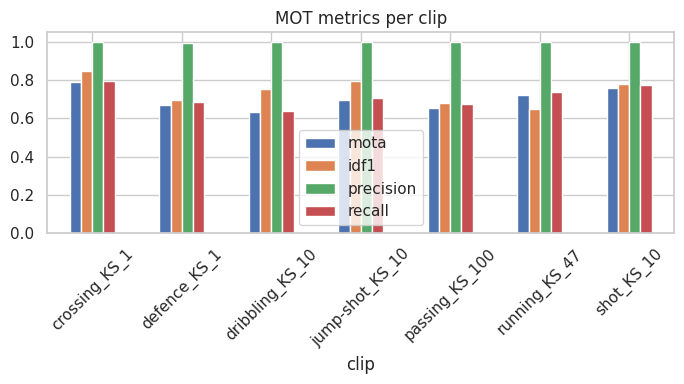

In [30]:
plt.figure(figsize=(8,4))
(df_mot_all[['mota','idf1','precision','recall']].astype(float).plot(kind='bar', rot=45))
plt.title("MOT metrics per clip")
plt.tight_layout()
plt.savefig(os.path.join(trackresults_dir,"Mot_Metrics_Bars_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Visualization Tracks**

In [31]:
def render_tracks_video(csv_path: str, pred_tracks_csv: str|None=None, out_mp4: str|None=None, conf_thr: float=0.2, trail: int=20):

    df = load_uniri_csv(csv_path)
    vid = video_path_from_csv(csv_path)
    assert os.path.exists(vid), f"Missing video: {vid}"
    cap = cv2.VideoCapture(vid)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0

    if pred_tracks_csv is None:

        _, pred_tracks_csv = build_pred_tracks_with_deepsort(csv_path, conf_thr=conf_thr)

    pr = pd.read_csv(pred_tracks_csv)

    if out_mp4 is None:

        out_mp4 = os.path.join(trackresults_dir, f"{Path(csv_path).stem}_Pred_Vis_Kosmas_Katsioulas_ME2109.mp4")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vw = cv2.VideoWriter(out_mp4, fourcc, fps, (w, h))

    history = {}
    fmin, fmax = int(pr.frame.min()), int(pr.frame.max())

    for f in range(fmin, fmax + 1):

        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, f - 1))
        ok, frame = cap.read()

        if not ok:
            break

        sub = pr[pr.frame == f]
        canvas = frame.copy()

        for _, r in sub.iterrows():

            x1, y1, x2, y2, tid = r.x1, r.y1, r.x2, r.y2, int(r.id)
            col = color_for_id(tid)

            # bbox
            cv2.rectangle(canvas, (int(x1), int(y1)), (int(x2), int(y2)), col, 2)

            # Label
            cv2.putText(canvas, f"ID{tid}",
                        (int(x1), max(0, int(y1) - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2, cv2.LINE_AA)

            # Trail
            xc, yc = (x1 + x2) / 2, (y1 + y2) / 2
            q = history.setdefault(tid, [])
            q.append((xc, yc))
            if len(q) > trail:
                q.pop(0)
            for i in range(1, len(q)):
                cv2.line(canvas, (int(q[i - 1][0]), int(q[i - 1][1])),
                                 (int(q[i][0]),     int(q[i][1])), col, 2)
        vw.write(canvas)

    cap.release()
    vw.release()
    print("Saved vis:", out_mp4)

In [32]:
if clips_to_eval:
    render_tracks_video(clips_to_eval[0], trail=25)

Saved Pred: /content/Track_Data/dribbling_KS_10_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 961
Saved vis: /content/Tracking_Results/dribbling_KS_10_Pred_Vis_Kosmas_Katsioulas_ME2109.mp4


# **Homography**

In [33]:
pixel_quad = np.float32([[50,680],[1230,680],[1230,50],[50,50]])
court_quad = np.float32([[0,20],[40,20],[40,0],[0,0]])

In [34]:
H_PIX_TO_M, _ = cv2.findHomography(pixel_quad, court_quad)

In [35]:
def footpoint_xyxy_to_point(x1,y1,x2,y2):

    return (x1+x2)/2.0, y2

In [36]:
def project_point_to_meters(xp, yp, H=H_PIX_TO_M):

    pt = np.array([[[xp, yp]]], dtype=np.float32)
    xm, ym = cv2.perspectiveTransform(pt, H)[0][0]

    return float(xm), float(ym)

In [37]:
def speeds_from_track(frames_xy_m, fps):

    if len(frames_xy_m) < 2:
        return []

    v = []

    for (f1,x1,y1),(f2,x2,y2) in zip(frames_xy_m[:-1], frames_xy_m[1:]):

        dt = max(1e-6, (f2 - f1) / fps)
        d  = float(np.hypot(x2-x1, y2-y1))
        v.append(d / dt)

    return v

# **Ablation Method**

In [38]:
def evaluate_ablation_mps(csv_path, frame_step=1, conf_thr=0.2, H=None, deepsort_base_age=15):

    df  = load_uniri_csv(csv_path)
    vid = video_path_from_csv(csv_path)
    cap = cv2.VideoCapture(vid); assert cap.isOpened()
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0

    if H is None: H = H_PIX_TO_M

    max_age = int(deepsort_base_age * frame_step)
    trkr = DeepSort(max_age=max_age, n_init=3, max_cosine_distance=0.4, embedder='mobilenet', half=False, bgr=True)

    tracks = {}
    fidx=0
    while True:

        ok, frame = cap.read()

        if not ok: break

        fidx += 1

        if fidx % frame_step != 0:

            continue

        sub = df[df.frame == fidx]
        dets=[]

        for _, r in sub.iterrows():

            if float(r.conf) < conf_thr:

                continue

            w = max(0.0, r.x2-r.x1); h = max(0.0, r.y2-r.y1)

            if w<=1 or h<=1:

                continue

            dets.append(([float(r.x1), float(r.y1), float(w), float(h)], float(r.conf), 'player'))

        tracks_out = trkr.update_tracks(dets, frame=frame)

        for tr in tracks_out:

            if not tr.is_confirmed():

                continue

            l,t,r,b = tr.to_ltrb()
            xp, yp  = footpoint_xyxy_to_point(l,t,r,b)
            xm, ym  = project_point_to_meters(xp, yp, H)
            tracks.setdefault(tr.track_id, []).append((fidx, xm, ym))

    cap.release()

    v_all, total_dist = [], []

    for tid, seq in tracks.items():

        seq = sorted(seq, key=lambda z: z[0])
        v   = speeds_from_track(seq, fps=fps)

        if v:

            v_all.extend(v)
            d = np.sum([np.hypot(seq[i+1][1]-seq[i][1], seq[i+1][2]-seq[i][2]) for i in range(len(seq)-1)])
            total_dist.append(d)

    return {
        "fs": frame_step,
        "mean_speed_mps":   float(np.mean(v_all) if v_all else 0.0),
        "median_speed_mps": float(np.median(v_all) if v_all else 0.0),
        "tracks":           int(len(tracks)),
        "mean_total_dist_m":float(np.mean(total_dist) if total_dist else 0.0),
        "max_age_used":     max_age
    }

In [39]:
ablation_rows=[]
frame_steps=[1,5,10,30]

for cp in clips_to_eval[:3]:

    for fs in frame_steps:

        r = evaluate_ablation_mps(cp, frame_step=fs, conf_thr=0.2, H=H_PIX_TO_M)
        r["clip"] = Path(cp).stem
        ablation_rows.append(r)

In [40]:
df_ablation = pd.DataFrame(ablation_rows)
display(df_ablation.head())
df_ablation.to_csv(os.path.join(trackresults_dir, "Ablation_mps_Kosmas_Katsioulas_ME2109.csv"), index=False)

,fs,mean_speed_mps,median_speed_mps,tracks,mean_total_dist_m,max_age_used,clip
0,1,7.091884,2.979765,24,5.774086,15,dribbling_KS_10
1,5,3.581535,2.017196,13,3.447231,75,dribbling_KS_10
2,10,2.576549,1.324275,8,1.544790,150,dribbling_KS_10
3,30,0.000000,0.000000,0,0.000000,450,dribbling_KS_10
4,1,5.830096,3.331369,30,6.245258,15,passing_KS_100


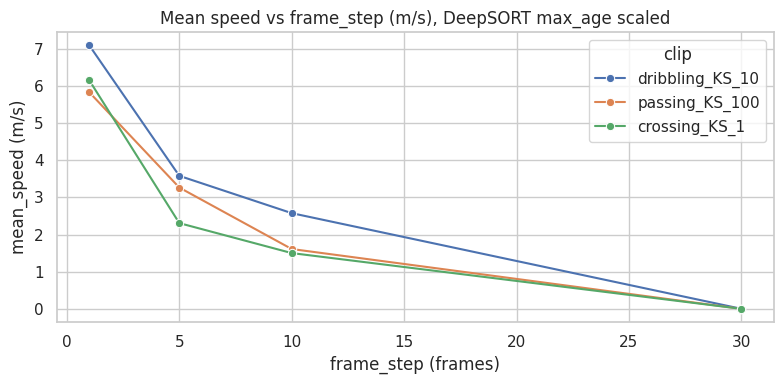

In [41]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df_ablation, x="fs", y="mean_speed_mps", hue="clip", marker="o")
plt.ylabel("mean_speed (m/s)")
plt.xlabel("frame_step (frames)");
plt.title("Mean speed vs frame_step (m/s), DeepSORT max_age scaled")
plt.tight_layout()
plt.savefig(os.path.join(trackresults_dir, "Abl_mean_speed_mps_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Trajectories Statistics**

In [42]:
def traj_stats_from_tracks_mps(pred_tracks_csv: str, video_path: str, H=H_PIX_TO_M):

    pr  = pd.read_csv(pred_tracks_csv)
    cap = cv2.VideoCapture(video_path); fps = cap.get(cv2.CAP_PROP_FPS) or 25.0; cap.release()
    trajs={}

    for _, r in pr.iterrows():

        f,tid,x1,y1,x2,y2 = int(r.frame), int(r.id), r.x1,r.y1,r.x2,r.y2
        xp, yp = footpoint_xyxy_to_point(x1,y1,x2,y2)
        xm, ym = project_point_to_meters(xp, yp, H)
        trajs.setdefault(tid, []).append((f,xm,ym))

    rows=[]

    for tid, seq in trajs.items():

        seq = sorted(seq, key=lambda z:z[0])
        v   = speeds_from_track(seq, fps=fps)

        if not v:

            continue

        dist = np.sum([np.hypot(seq[i+1][1]-seq[i][1], seq[i+1][2]-seq[i][2]) for i in range(len(seq)-1)])
        rows.append({"id":tid, "mean_speed_mps":float(np.mean(v)), "max_speed_mps":float(np.max(v)), "total_dist_m":float(dist), "n":len(seq)})

    return pd.DataFrame(rows)

Saved Pred: /content/Track_Data/dribbling_KS_10_Pred_Deepsort_Kosmas_Katsioulas_ME2109.csv | rows: 961


,id,mean_speed_mps,max_speed_mps,total_dist_m,n
0,1,2.892947,8.993043,3.740464,63
1,10,3.744468,20.608558,4.841445,63
2,12,9.423064,21.395009,12.183642,63
3,14,1.370619,6.113543,1.772154,63
4,16,4.551887,53.877599,3.322407,36


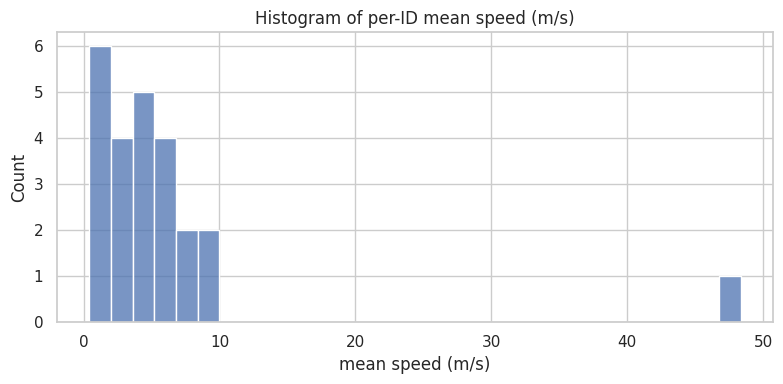

In [43]:
if clips_to_eval:

    clip = clips_to_eval[0]
    pr_df, pr_csv = build_pred_tracks_with_deepsort(clip, conf_thr=0.2)
    vid = video_path_from_csv(clip)
    st  = traj_stats_from_tracks_mps(pr_csv, vid, H=H_PIX_TO_M)
    st.to_csv(os.path.join(trackresults_dir, "Traj_Stats_mps_Kosmas_Katsioulas_ME2109.csv"), index=False)
    display(st.head())

    plt.figure(figsize=(8,4))
    sns.histplot(st['mean_speed_mps'], bins=30)
    plt.xlabel("mean speed (m/s)")
    plt.title("Histogram of per-ID mean speed (m/s)")
    plt.tight_layout()
    plt.savefig(os.path.join(trackresults_dir,"Hist_Mean_Speed_mps_Kosmas_Katsioulas_ME2109.png"))
    plt.show()